In [1]:
from functions import *
from step1_functions import *
from time_stitches import *
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
#function for x dicrimination
def remove_extreme_using_x_pos(nh_rec, tw_rec, prop_nh=0.5, prop_tw=0.5):
    """Create a mask keeping all points which are between two extreme values"""
    nh_threshold_x = (nh_rec['X.1'].max() - nh_rec['X.1'].median())*prop_nh #remove all points above it
    tw_threshold_x = (tw_rec['X.1'].min() - tw_rec['X.1'].median())*prop_tw #remove all points below it

    selected_nh = (nh_rec['X.1']<nh_threshold_x)
    selected_tw = (tw_rec['X.1']>tw_threshold_x)

    return selected_nh, selected_tw

In [3]:
def compute_mask_using_v(nh_rec, tw_rec, smooth_window=60, prop_nh=0.4, prop_tw=0.4):
    """Compute masks to discriminate periods when tools go to extreme positions ie when velocity reaches high/low values. 
        It gives for each tool a mask where velocity is more extreme than a threshold and another where it is lower than another threshold"""
    smooth_vx_nh, smooth_accx_nh = compute_v_acc(nh_rec, smooth_box=smooth_window, smooth_ = True)
    
    smooth_vx_tw, smooth_accx_tw = compute_v_acc(tw_rec, smooth_box=smooth_window, smooth_ = True)

    nh_max_threshold_vx = max(smooth_vx_nh)*prop_nh #initially /2
    nh_min_threshold_vx = min(smooth_vx_nh)*prop_nh
    mask_vx_max_nh = (smooth_vx_nh <nh_max_threshold_vx)
    mask_vx_min_nh = (smooth_vx_nh >nh_min_threshold_vx)

    tw_min_threshold_vx = min(smooth_vx_tw)*prop_tw
    tw_max_threshold_vx = max(smooth_vx_tw)*prop_tw
    mask_vx_min_tw = (smooth_vx_tw > tw_min_threshold_vx)
    mask_vx_max_tw = (smooth_vx_tw < tw_max_threshold_vx)

    return [mask_vx_min_nh, mask_vx_max_nh], [mask_vx_min_tw, mask_vx_max_tw]

In [4]:
def compute_event_time(segments_time_i, selected_data_nh, selected_data_tw, mask_vx_min_nh,  mask_vx_max_nh, mask_vx_min_tw, mask_vx_max_tw):
    start_t_task = segments_time_i['1'][0] #beginning of first stitch
    end_t_task = segments_time_i['8'][1] #end of last stitch

    """Needle Holder"""
    #give the position of last True before changing to False (juste before reaching v threshold to exclude points)
    start_pic_max_nh = list(np.where(np.diff(mask_vx_max_nh.astype(int)) == -1)[0])
    #want the position of the last false before a new True
    end_pic_min_nh = list(np.where(np.diff(mask_vx_min_nh.astype(int)) == 1)[0])

    time_start_pic_max_nh_ = list(selected_data_nh.iloc[start_pic_max_nh]['Time (Seconds)'])
    #remove picks which start before the beginning of the task or after the end of the task
    time_start_pic_max_nh = [x for x in time_start_pic_max_nh_ if ((x >= start_t_task) & (x <= end_t_task))]

    time_end_pic_min_nh_ = list(selected_data_nh.iloc[end_pic_min_nh]['Time (Seconds)'])
    #remove picks which start before the beginning of the task or after the end of the task
    time_end_pic_min_nh = [x for x in time_end_pic_min_nh_ if ((x >= start_t_task) & (x <= end_t_task))]

    """Tweezers"""
    #give the position of last True before changing to False (juste before reaching v threshold to exclude points)
    start_pic_max_tw = list(np.where(np.diff(mask_vx_min_tw.astype(int)) == -1)[0])
    #want the position of the last false before a new True
    end_pic_min_tw = list(np.where(np.diff(mask_vx_max_tw.astype(int)) == 1)[0])

    time_start_pic_max_tw_ = list(selected_data_tw.iloc[start_pic_max_tw]['Time (Seconds)'])
    #remove picks which start before the beginning of the task or after the end of the task
    time_start_pic_max_tw = [x for x in time_start_pic_max_tw_ if ((x >= start_t_task) & (x <= end_t_task))]

    time_end_pic_min_tw_ = list(selected_data_tw.iloc[end_pic_min_tw]['Time (Seconds)'])
    #remove picks which start before the beginning of the task or after the end of the task
    time_end_pic_min_tw = [x for x in time_end_pic_min_tw_ if ((x >= start_t_task) & (x <= end_t_task))]

    return [time_start_pic_max_nh, time_end_pic_min_nh], [time_start_pic_max_tw, time_end_pic_min_tw]

    

In [5]:
#initial version
def compute_pairs_time(time_start_pic_max, time_end_pic_min, delta_t=30):
    pairs = []
    for start in time_start_pic_max:
        delta_t = 30 #delta t max allowed is 30 s
        pair = []
        for end in time_end_pic_min:
            if (((end-start)<(delta_t)) & ((end-start)>0)):
                delta_t = end-start
                pair = [start-0.5, end+0.5] #we allow to take values 0.5s before and after the event time
        if pair: pairs.append(pair)
    return pairs

In [6]:
#version 3
def compute_pairs_time(time_start_pic_max, time_end_pic_min, delta_t=60):
    pairs = []
    for start in (time_start_pic_max):
        end_times = np.array(time_end_pic_min)
        later_than_start = end_times[end_times>start]
        if (len(later_than_start)!=0):
            closest_end_time = later_than_start[(later_than_start-start).argmin()]
            if ((closest_end_time-start)<delta_t): 
                pairs.append([start-0.5, closest_end_time+0.5])
    return pairs

In [7]:
def remove_extreme(selected_data, pairs_t):
    """Return a mask of values to keep ie values that are not in the interval where velocity reaches extreme values"""
    mask = np.ones(len(selected_data), dtype=bool) 
    for t_start, t_end in pairs_t:
        mask &= (selected_data['Time (Seconds)'] < (t_start)) | (selected_data['Time (Seconds)'] > (t_end ))
    return mask

In [8]:
def adjust_time_pair(data, pairs, median_x, time_allowed = 5): #before 3s
    #adjust time so that it corresponds when the position is close to the median = ref point of the task
    new_pairs = []
    for start, end in pairs:
        interval_min = start - time_allowed/2
        interval_max = end + time_allowed/2

        #initialise in case we don't have new start/end
        new_start = start 
        new_end = end

        data_before = data[(data['Time (Seconds)']>interval_min) & (data['Time (Seconds)']<start)].reset_index(drop=True)
        data_after = data[(data['Time (Seconds)']>end) & (data['Time (Seconds)']<interval_max)].reset_index(drop=True)

        condition_b = np.abs(data_before['X.1']-median_x)<0.005
        if (np.sum(condition_b)>0):
            # we want the last time where we were close to the ref line (ie median)
            new_start_index = (data_before[condition_b]['X.1']).argmax() 
            new_start = data_before.loc[int(new_start_index)]['Time (Seconds)']

        condition_a = np.abs(data_after['X.1']-median_x)<0.005
        if (np.sum(condition_a)>0):
            # we want the first time we are cross the ref line (ie median)
            new_end_index = (data_after[condition_a]['X.1']).argmin()
            new_end = data_after.loc[int(new_end_index)]['Time (Seconds)']

        new_pairs.append([new_start, new_end])
    return new_pairs


In [9]:
def compute_event_time_pos(segments_time_i, selected_data_nh, selected_data_tw, mask_x_nh, mask_x_tw):
    start_t_task = segments_time_i['1'][0] #beginning of first stitch
    end_t_task = segments_time_i['8'][1] #end of last stitch

    """Needle Holder"""
    #give the position of last True before changing to False (juste before reaching v threshold to exclude points)
    start_pic_max_nh = list(np.where(np.diff(mask_x_nh.astype(int)) == -1)[0])
    #want the position of the last false before a new True
    end_pic_min_nh = list(np.where(np.diff(mask_x_nh.astype(int)) == 1)[0])

    time_start_pic_max_nh_ = list(selected_data_nh.iloc[start_pic_max_nh]['Time (Seconds)'])
    #remove picks who start before the beginning of the task or after the end of the task
    time_start_pic_max_nh = [x for x in time_start_pic_max_nh_ if ((x >= start_t_task) & (x <= end_t_task))]

    time_end_pic_min_nh_ = list(selected_data_nh.iloc[end_pic_min_nh]['Time (Seconds)'])
    #remove picks who start before the beginning of the task or after the end of the task
    time_end_pic_min_nh = [x for x in time_end_pic_min_nh_ if ((x >= start_t_task) & (x <= end_t_task))]

    """Tweezers"""
    #give the position of last True before changing to False (juste before reaching v threshold to exclude points)
    start_pic_max_tw = list(np.where(np.diff(mask_x_tw.astype(int)) == -1)[0])
    #want the position of the last false before a new True
    end_pic_min_tw = list(np.where(np.diff(mask_x_tw.astype(int)) == 1)[0])

    time_start_pic_max_tw_ = list(selected_data_tw.iloc[start_pic_max_tw]['Time (Seconds)'])
    #remove picks who start before the beginning of the task or after the end of the task
    time_start_pic_max_tw = [x for x in time_start_pic_max_tw_ if ((x >= start_t_task) & (x <= end_t_task))]

    time_end_pic_min_tw_ = list(selected_data_tw.iloc[end_pic_min_tw]['Time (Seconds)'])
    #remove picks who start before the beginning of the task or after the end of the task
    time_end_pic_min_tw = [x for x in time_end_pic_min_tw_ if ((x >= start_t_task) & (x <= end_t_task))]

    return [time_start_pic_max_nh, time_end_pic_min_nh], [time_start_pic_max_tw, time_end_pic_min_tw]

In [10]:
#function to put a threshold on Z axis using the already x-selected signal
def remove_extreme_using_z_pos(nh_selected, tw_selected, medians_nh, medians_tw):
    """Create a mask keeping all points which are between two extreme values"""
    median_nh_z = medians_nh['Z.1']
    median_tw_z = medians_tw['Z.1']
    std_z_nh = nh_selected['Z.1'].std()
    std_z_tw = tw_selected['Z.1'].std()

    #A deviation from the main task (median) of 0.02m is considered as reasonable
    nh_threshold_z_min= median_nh_z - max(0.02, std_z_nh)
    nh_threshold_z_max= median_nh_z + max(0.02, std_z_nh)
    tw_threshold_z_min= median_tw_z - max(0.02, std_z_tw)
    tw_threshold_z_max= median_tw_z + max(0.02, std_z_tw)

    mask_selected_nh = (nh_selected['Z.1']<nh_threshold_z_max) & (nh_selected['Z.1']>nh_threshold_z_min)
    mask_selected_tw = (tw_selected['Z.1']<tw_threshold_z_max) & (tw_selected['Z.1']>tw_threshold_z_min)

    return mask_selected_nh, mask_selected_tw

In [19]:
#function to put a threshold on Z axis using the already x-selected signal
def remove_extreme_using_z_pos2(nh_rec, tw_rec, stds_nh, stds_tw, medians_nh, medians_tw):
    """Create a mask keeping all points which are between two extreme values"""
    median_nh_z = medians_nh['Z.1']
    median_tw_z = medians_tw['Z.1']
    std_z_nh = stds_nh['Z.1']
    std_z_tw = stds_tw['Z.1']

    #A deviation from the main task (median) of 0.02m is considered as reasonable
    nh_threshold_z_min= median_nh_z - max(0.02, std_z_nh)
    nh_threshold_z_max= median_nh_z + max(0.02, std_z_nh)
    tw_threshold_z_min= median_tw_z - max(0.02, std_z_tw)
    tw_threshold_z_max= median_tw_z + max(0.02, std_z_tw)

    mask_selected_nh = (nh_rec['Z.1']<nh_threshold_z_max) & (nh_rec['Z.1']>nh_threshold_z_min)
    mask_selected_tw = (tw_rec['Z.1']<tw_threshold_z_max) & (tw_rec['Z.1']>tw_threshold_z_min)

    return mask_selected_nh, mask_selected_tw

In [35]:
#function to put a threshold on Y axis using the already x-selected signal
def remove_extreme_using_y_pos(nh_rec, tw_rec, stds_nh, stds_tw, medians_nh, medians_tw):
    """Create a mask keeping all points which are between two extreme values"""
    median_nh_y = medians_nh['Y.1']
    median_tw_y = medians_tw['Y.1']
    std_y_nh = stds_nh['Y.1']
    std_y_tw = stds_tw['Y.1']

    #A deviation from the main task (median) of 0.015m is considered as reasonable
    nh_threshold_y_min= median_nh_y - max(0.015, std_y_nh)
    nh_threshold_y_max= median_nh_y + max(0.015, std_y_nh)
    tw_threshold_y_min= median_tw_y - max(0.015, std_y_tw)
    tw_threshold_y_max= median_tw_y + max(0.015, std_y_tw)

    mask_selected_nh = (nh_rec['Y.1']<nh_threshold_y_max) & (nh_rec['Y.1']>nh_threshold_y_min)
    mask_selected_tw = (tw_rec['Y.1']<tw_threshold_y_max) & (tw_rec['Y.1']>tw_threshold_y_min)

    return mask_selected_nh, mask_selected_tw

In [46]:
#function to put a threshold on Y axis using the already x-selected signal
def remove_extreme_using_x_pos_on_selected_data(nh_rec, tw_rec, stds_nh, stds_tw, medians_nh, medians_tw):
    """Create a mask keeping all points which are between two extreme values"""
    median_nh_x = medians_nh['X.1']
    median_tw_x = medians_tw['X.1']
    std_x_nh = stds_nh['X.1']
    std_x_tw = stds_tw['X.1']

    #A deviation from the main task (median) of 0.015m is considered as reasonable. Being far away than 0.04m is considered as not reasonable
    nh_threshold_x_min= median_nh_x - min(0.04, max(0.015, std_x_nh))
    nh_threshold_x_max= median_nh_x + min(0.04, max(0.015, std_x_nh))
    tw_threshold_x_min= median_tw_x - min(0.04, max(0.015, std_x_tw))
    tw_threshold_x_max= median_tw_x + min(0.04, max(0.015, std_x_tw))

    mask_selected_nh = (nh_rec['X.1']<nh_threshold_x_max) & (nh_rec['X.1']>nh_threshold_x_min)
    mask_selected_tw = (tw_rec['X.1']<tw_threshold_x_max) & (tw_rec['X.1']>tw_threshold_x_min)

    return mask_selected_nh, mask_selected_tw

In [28]:
#subject 19 had a very define shift between the beginning and the end of the task in term of z axis, then we treat it separately
def remove_extreme_using_z_pos2_sub19(nh_rec, tw_rec): 
    """Create a mask keeping all points which are between two extreme values"""
    part1_nh = nh_rec[nh_rec['Time (Seconds)']<600*120]
    part1_tw = tw_rec[tw_rec['Time (Seconds)']<600*120]
    part2_nh = nh_rec[nh_rec['Time (Seconds)']>600*120]
    part2_tw = tw_rec[tw_rec['Time (Seconds)']>600*120]

    median_nh_part1 = part1_nh['Z.1'].median()
    median_tw_part1 = part1_tw['Z.1'].median()
    median_nh_part2 = part2_nh['Z.1'].median()
    median_tw_part2 = part2_tw['Z.1'].median()

    std_nh_part1 = part1_nh['Z.1'].std()
    std_tw_part1 = part1_tw['Z.1'].std()
    std_nh_part2 = part2_nh['Z.1'].std()
    std_tw_part2 = part2_tw['Z.1'].std()

    #A deviation from the main task (median) of 0.02m is considered as reasonable
    nh_threshold_z_min_part1= median_nh_part1 - max(0.02, std_nh_part1)
    nh_threshold_z_min_part2= median_nh_part2 - max(0.02, std_nh_part2)
    nh_threshold_z_max_part1= median_nh_part1 + max(0.02, std_nh_part1)
    nh_threshold_z_max_part2= median_nh_part2 + max(0.02, std_nh_part2)
    tw_threshold_z_min_part1= median_tw_part1 - max(0.02, std_tw_part1)
    tw_threshold_z_min_part2= median_tw_part2 - max(0.02, std_tw_part2)
    tw_threshold_z_max_part1= median_tw_part1 + max(0.02, std_tw_part1)
    tw_threshold_z_max_part2= median_tw_part2 + max(0.02, std_tw_part2)

    mask_selected_nh_part1 = (nh_rec['Z.1']<nh_threshold_z_max_part1) & (nh_rec['Z.1']>nh_threshold_z_min_part1)
    mask_selected_nh_part2 = (nh_rec['Z.1']<nh_threshold_z_max_part2) & (nh_rec['Z.1']>nh_threshold_z_min_part2)
    mask_selected_tw_part1 = (tw_rec['Z.1']<tw_threshold_z_max_part1) & (tw_rec['Z.1']>tw_threshold_z_min_part1)
    mask_selected_tw_part2 = (tw_rec['Z.1']<tw_threshold_z_max_part2) & (tw_rec['Z.1']>tw_threshold_z_min_part2)

    mask_selected_nh = pd.concat([mask_selected_nh_part1, mask_selected_nh_part2], axis=0, ignore_index=True)
    mask_selected_tw = pd.concat([mask_selected_tw_part1, mask_selected_tw_part2], axis=0, ignore_index=True)
    return mask_selected_nh, mask_selected_tw

Std nh X.1    0.017141
Y.1    0.016643
Z.1    0.012426
dtype: float64
Std tw X.1    0.019168
Y.1    0.019446
Z.1    0.014345
dtype: float64


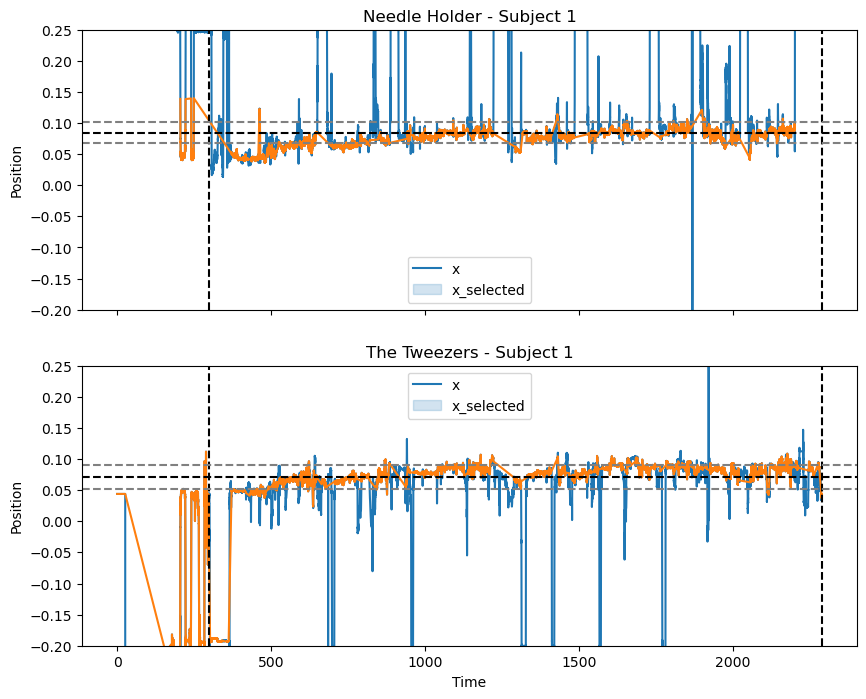

Std nh X.1    0.016911
Y.1    0.021903
Z.1    0.024553
dtype: float64
Std tw X.1    0.072618
Y.1    0.022911
Z.1    0.049883
dtype: float64


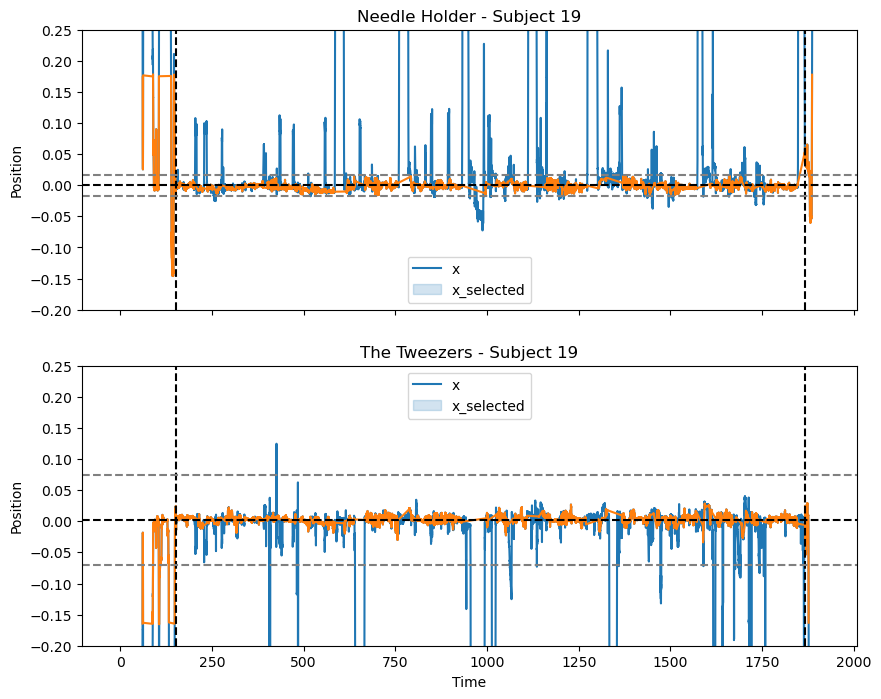

Std nh X.1    0.021961
Y.1    0.018892
Z.1    0.028318
dtype: float64
Std tw X.1    0.016237
Y.1    0.018414
Z.1    0.033660
dtype: float64


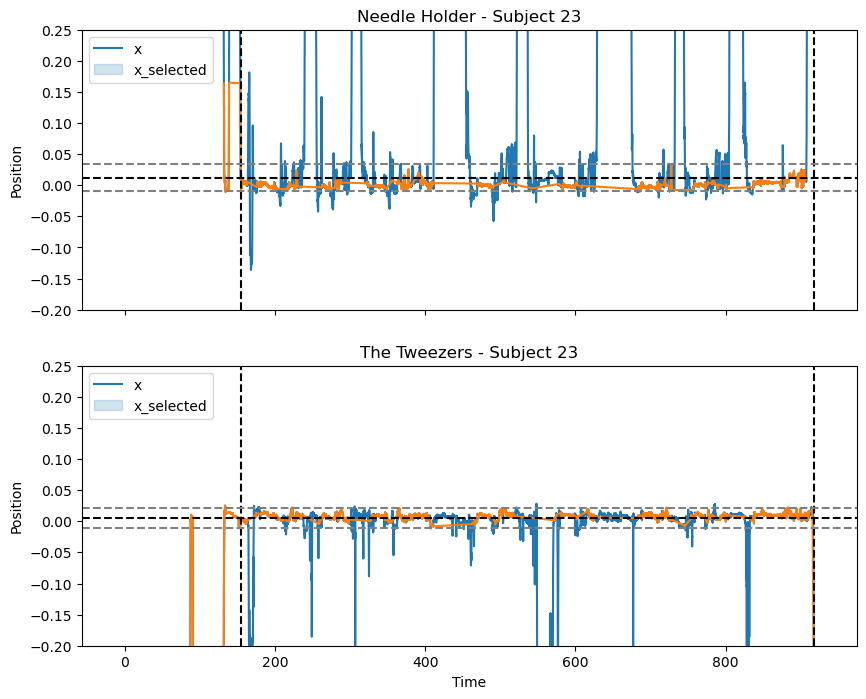

Std nh X.1    0.019294
Y.1    0.022722
Z.1    0.027078
dtype: float64
Std tw X.1    0.120287
Y.1    0.022932
Z.1    0.027217
dtype: float64


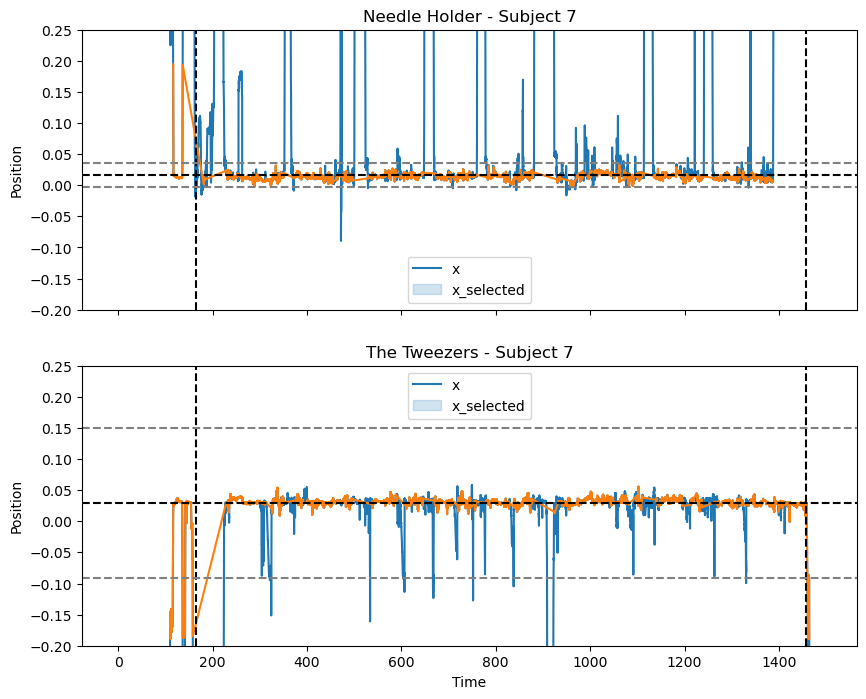

Std nh X.1    0.020484
Y.1    0.040358
Z.1    0.049553
dtype: float64
Std tw X.1    0.024149
Y.1    0.022120
Z.1    0.013822
dtype: float64


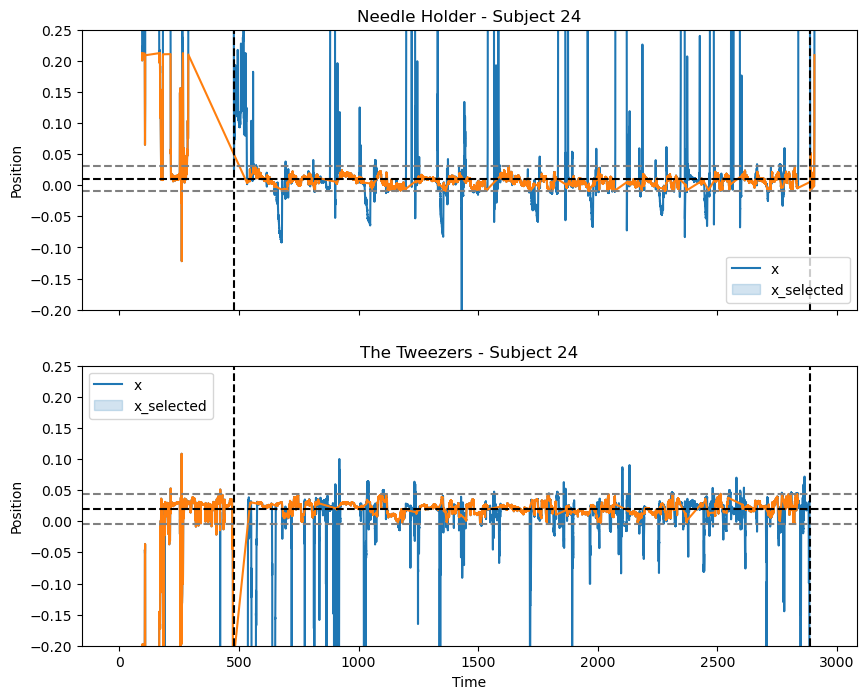

Std nh X.1    0.028964
Y.1    0.031556
Z.1    0.039057
dtype: float64
Std tw X.1    0.024502
Y.1    0.028938
Z.1    0.020607
dtype: float64


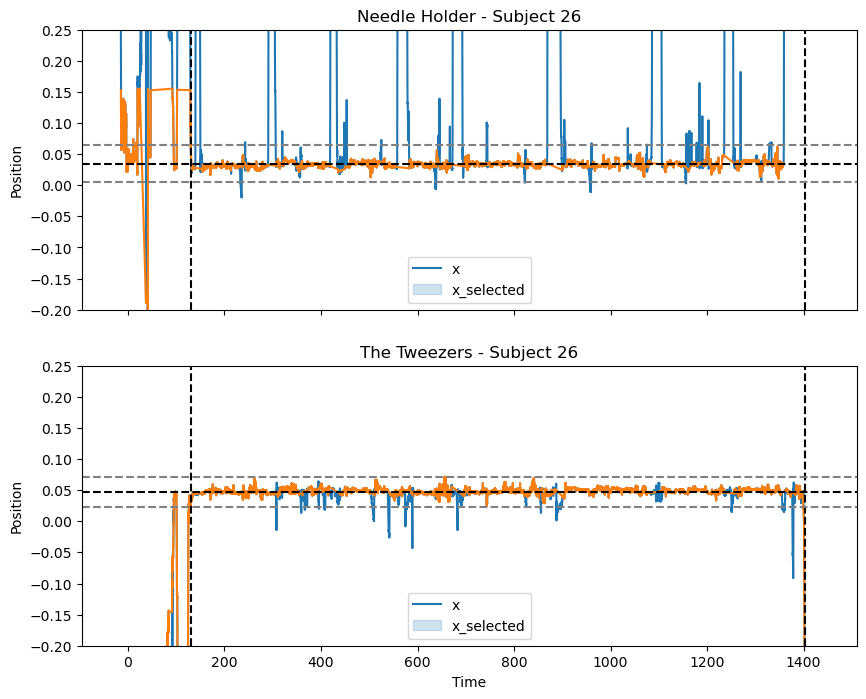

Std nh X.1    0.019287
Y.1    0.015381
Z.1    0.012868
dtype: float64
Std tw X.1    0.058541
Y.1    0.017483
Z.1    0.019759
dtype: float64


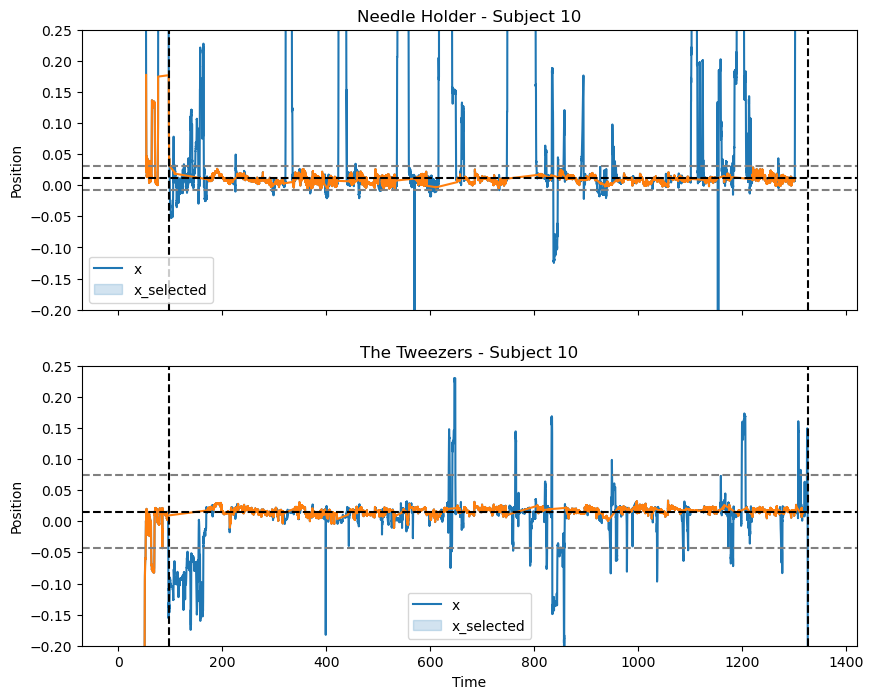

Std nh X.1    0.027661
Y.1    0.024466
Z.1    0.026040
dtype: float64
Std tw X.1    0.037925
Y.1    0.017476
Z.1    0.034161
dtype: float64


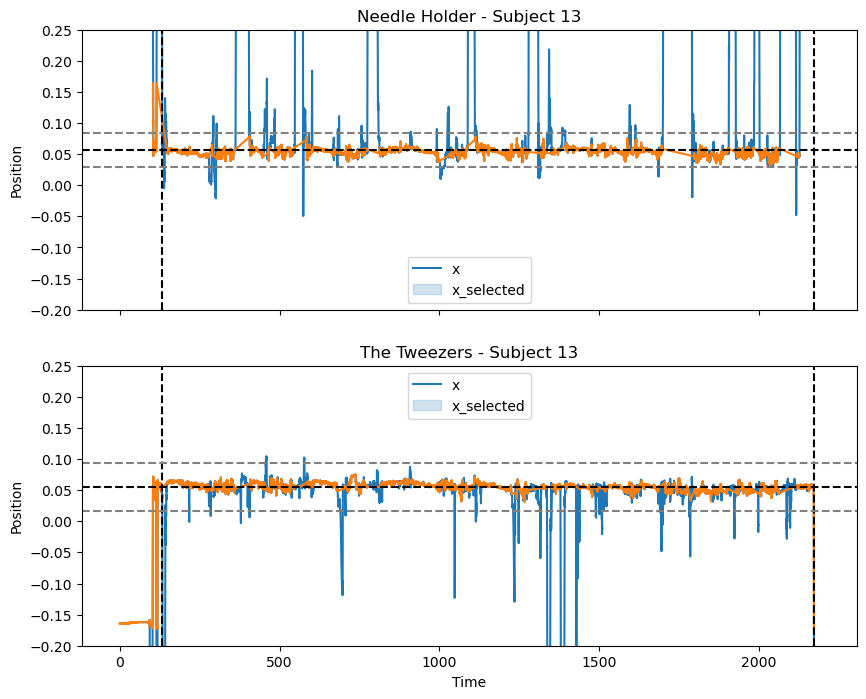

Std nh X.1    0.011989
Y.1    0.013588
Z.1    0.024133
dtype: float64
Std tw X.1    0.049306
Y.1    0.061238
Z.1    0.017136
dtype: float64


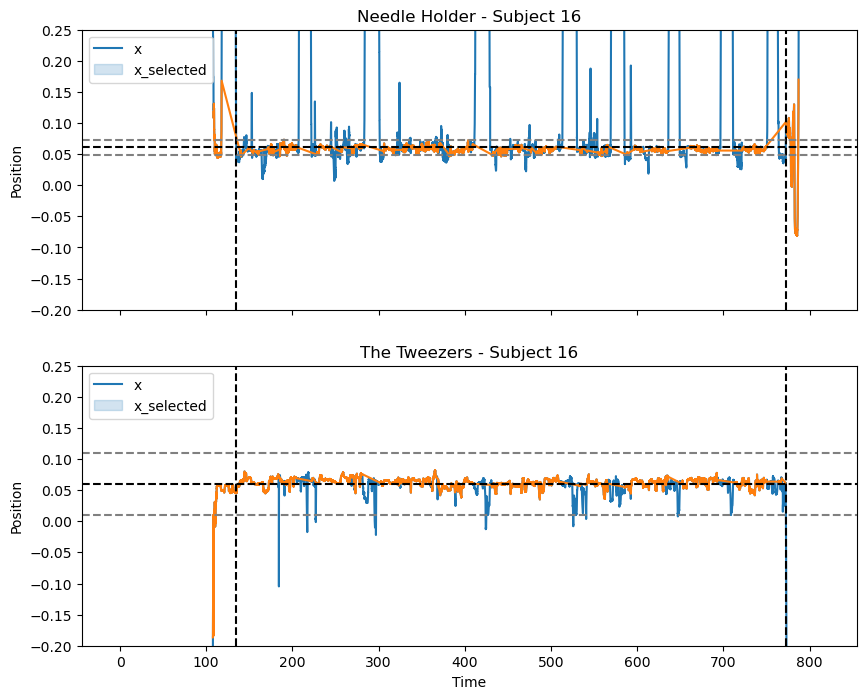

Std nh X.1    0.015972
Y.1    0.015028
Z.1    0.027792
dtype: float64
Std tw X.1    0.011966
Y.1    0.011120
Z.1    0.011316
dtype: float64


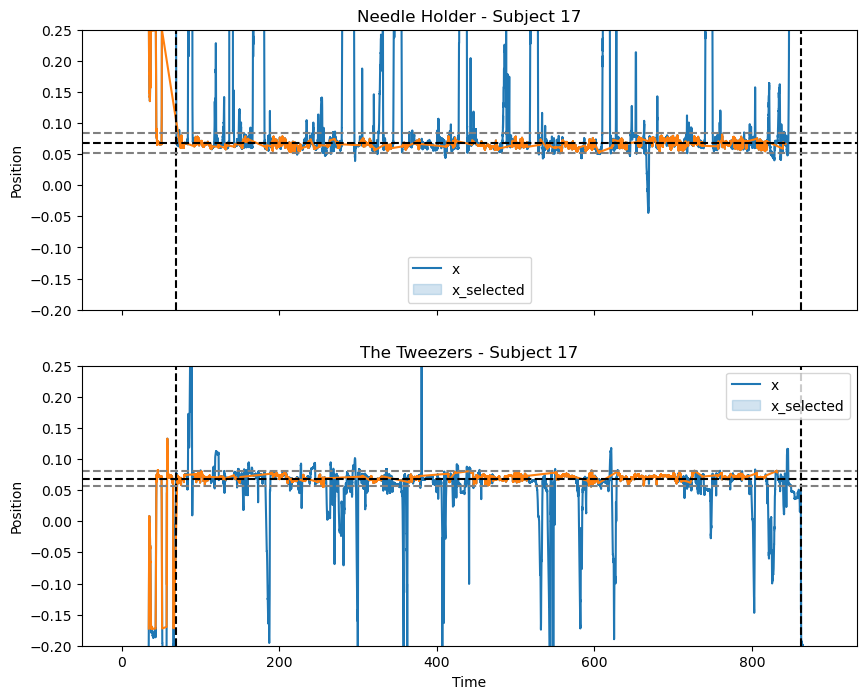

Std nh X.1    0.021704
Y.1    0.022248
Z.1    0.034244
dtype: float64
Std tw X.1    0.033253
Y.1    0.026860
Z.1    0.028023
dtype: float64


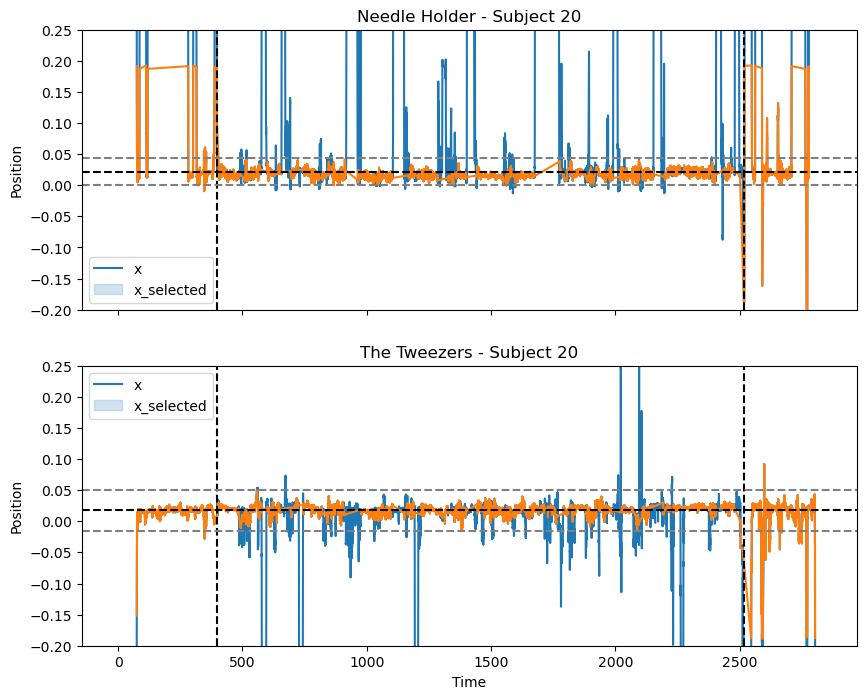

Std nh X.1    0.024184
Y.1    0.024090
Z.1    0.029678
dtype: float64
Std tw X.1    0.017360
Y.1    0.035692
Z.1    0.029623
dtype: float64


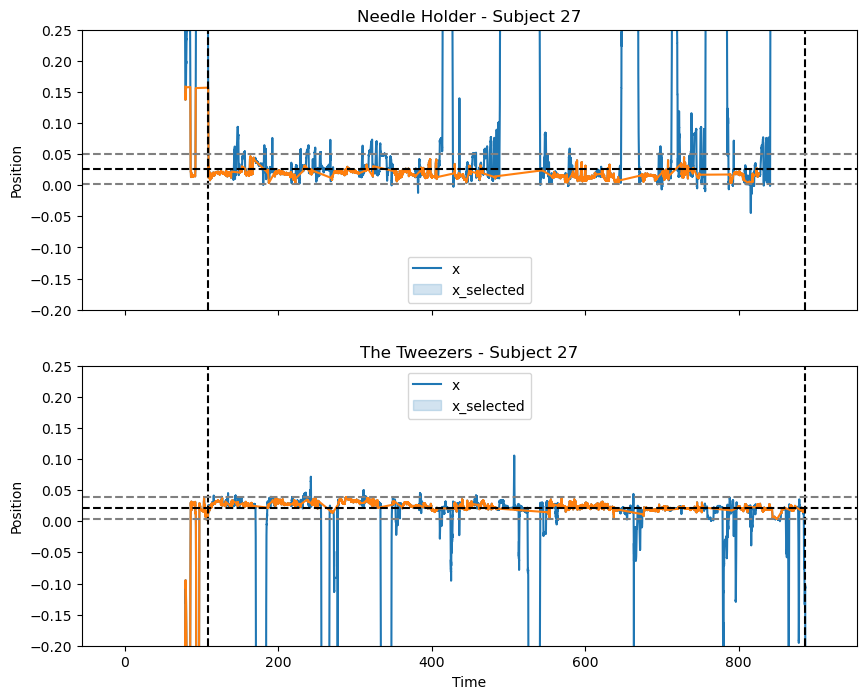

In [47]:
subjects = [1,19, 23,7, 24, 26, 10, 13, 16, 17, 20, 27]

i = 0
for subject in subjects:
    needle_holder_rec = pd.read_csv(f'Data/Sync_data/S_{subject}_NH_reconstructed.csv')
    tweezers_rec = pd.read_csv(f'Data/Sync_data/S_{subject}_TW_reconstructed.csv')

    medians_nh = (needle_holder_rec[['X.1', 'Y.1', 'Z.1']]).median()
    medians_tw = (tweezers_rec[['X.1', 'Y.1', 'Z.1']]).median()
    std_nh =  (selected_points_nh[['X.1', 'Y.1', 'Z.1']]).std()
    std_tw =  (selected_points_tw[['X.1', 'Y.1', 'Z.1']]).std()
    print('Std nh', std_nh)
    print('Std tw', std_tw)

    """X Position"""
    selected_xpos_nh, selected_xpos_tw = remove_extreme_using_x_pos(needle_holder_rec, tweezers_rec, prop_nh=0.5, prop_tw=0.5)
    time_event_xpos_nh, time_event_xpos_tw = compute_event_time_pos(full_segments_time[i], needle_holder_rec, tweezers_rec, selected_xpos_nh,
                                                                selected_xpos_tw)

    pairs_t_xpos_nh = compute_pairs_time(time_event_xpos_nh[0], time_event_xpos_nh[1])
    pairs_t_xpos_tw = compute_pairs_time(time_event_xpos_tw[0], time_event_xpos_tw[1])

    pairs_adjusted_t_xpos_nh = adjust_time_pair(needle_holder_rec, pairs_t_xpos_nh, medians_nh['X.1'], time_allowed = 6)
    pairs_adjusted_t_xpos_tw = adjust_time_pair(tweezers_rec, pairs_t_xpos_tw, medians_tw['X.1'], time_allowed=6)

    mask_extreme_xpos_event_removed_nh = remove_extreme(needle_holder_rec, pairs_adjusted_t_xpos_nh)
    mask_extreme_xpos_event_removed_tw = remove_extreme(tweezers_rec, pairs_adjusted_t_xpos_tw)

    """X Velocity"""
    mask_min_max_nh, mask_min_max_tw = compute_mask_using_v(needle_holder_rec, tweezers_rec, smooth_window=60, prop_nh=0.4, prop_tw=0.4)
    time_event_nh, time_event_tw = compute_event_time(full_segments_time[i], needle_holder_rec, tweezers_rec, mask_min_max_nh[0],  
                                                            mask_min_max_nh[1], mask_min_max_tw[0], mask_min_max_tw[1])
                
    pairs_t_nh = compute_pairs_time(time_event_nh[0], time_event_nh[1])
    pairs_t_tw = compute_pairs_time(time_event_tw[0], time_event_tw[1])

    pairs_adjusted_t_nh = adjust_time_pair(needle_holder_rec, pairs_t_nh, medians_nh['X.1'], time_allowed = 6)
    pairs_adjusted_t_tw = adjust_time_pair(tweezers_rec, pairs_t_tw, medians_tw['X.1'], time_allowed = 6)

    mask_extreme_v_event_removed_nh = remove_extreme(needle_holder_rec, pairs_adjusted_t_nh)
    mask_extreme_v_event_removed_tw = remove_extreme(tweezers_rec, pairs_adjusted_t_tw)
    mask_extreme_v_glass_nh = remove_extreme(needle_holder_rec, pairs_adjusted_t_tw) #we don't want to keep event when the other tool is in the glass
    mask_extreme_v_glass_tw = remove_extreme(tweezers_rec, pairs_adjusted_t_nh) #we don't want to keep event when the other tool is in the glass

    """Select points"""
    mask_glass_nh = mask_extreme_xpos_event_removed_nh & mask_extreme_v_event_removed_nh & selected_xpos_nh
    mask_glass_tw = mask_extreme_xpos_event_removed_tw & mask_extreme_v_event_removed_tw & selected_xpos_tw
    selected_points_nh = needle_holder_rec[mask_glass_nh & mask_extreme_v_glass_nh] #v is the most discriminative in this case compared to xpos
    selected_points_tw = tweezers_rec[mask_glass_tw & mask_extreme_v_glass_tw] #v is the most discriminative in this case compared to xpos

    """2nd selection based on z position"""
    #selected_zpos_nh, selected_zpos_tw = remove_extreme_using_z_pos(selected_points_nh, selected_points_tw, medians_nh, medians_tw)
    if (subject == 19): #subject 19 is treated separately 
        selected_zpos_nh, selected_zpos_tw = remove_extreme_using_z_pos2_sub19(needle_holder_rec, tweezers_rec)
    else:
        selected_zpos_nh, selected_zpos_tw = remove_extreme_using_z_pos2(needle_holder_rec, tweezers_rec, std_nh, std_tw, medians_nh, medians_tw)
    time_event_zpos_nh, time_event_zpos_tw = compute_event_time_pos(full_segments_time[i], needle_holder_rec, tweezers_rec, selected_zpos_nh,
                                                                selected_zpos_tw)

    pairs_t_zpos_nh = compute_pairs_time(time_event_zpos_nh[0], time_event_zpos_nh[1])
    pairs_t_zpos_tw = compute_pairs_time(time_event_zpos_tw[0], time_event_zpos_tw[1])

    pairs_adjusted_t_zpos_nh = adjust_time_pair(selected_points_nh, pairs_t_zpos_nh, medians_nh['Z.1'], time_allowed = 6)
    pairs_adjusted_t_zpos_tw = adjust_time_pair(selected_points_tw, pairs_t_zpos_tw, medians_tw['Z.1'], time_allowed=6)

    mask_extreme_zpos_event_removed_nh = remove_extreme(selected_points_nh, pairs_adjusted_t_zpos_nh)
    mask_extreme_zpos_event_removed_tw = remove_extreme(selected_points_tw, pairs_adjusted_t_zpos_tw)

    
    selected_points_nh2 = selected_points_nh[mask_extreme_zpos_event_removed_nh]
    selected_points_tw2 = selected_points_tw[mask_extreme_zpos_event_removed_tw]

    """2nd selection based on y position"""
    selected_ypos_nh, selected_ypos_tw = remove_extreme_using_y_pos(needle_holder_rec, tweezers_rec, std_nh, std_tw, medians_nh, medians_tw)
    time_event_ypos_nh, time_event_ypos_tw = compute_event_time_pos(full_segments_time[i], needle_holder_rec, tweezers_rec, selected_ypos_nh,
                                                                selected_ypos_tw)

    pairs_t_ypos_nh = compute_pairs_time(time_event_ypos_nh[0], time_event_ypos_nh[1])
    pairs_t_ypos_tw = compute_pairs_time(time_event_ypos_tw[0], time_event_ypos_tw[1])

    pairs_adjusted_t_ypos_nh = adjust_time_pair(selected_points_nh2, pairs_t_ypos_nh, medians_nh['Y.1'], time_allowed = 6)
    pairs_adjusted_t_ypos_tw = adjust_time_pair(selected_points_tw2, pairs_t_ypos_tw, medians_tw['Y.1'], time_allowed=6)

    mask_extreme_ypos_event_removed_nh = remove_extreme(selected_points_nh2, pairs_adjusted_t_ypos_nh)
    mask_extreme_ypos_event_removed_tw = remove_extreme(selected_points_tw2, pairs_adjusted_t_ypos_tw)

    
    selected_points_nh3 = selected_points_nh2[mask_extreme_ypos_event_removed_nh]
    selected_points_tw3 = selected_points_tw2[mask_extreme_ypos_event_removed_tw]

    """2nd selection based on x position"""
    if (subject!=1):
        selected_xpos2_nh, selected_xpos2_tw = remove_extreme_using_x_pos_on_selected_data(needle_holder_rec, tweezers_rec, std_nh, std_tw, medians_nh, medians_tw)
        time_event_xpos2_nh, time_event_xpos2_tw = compute_event_time_pos(full_segments_time[i], needle_holder_rec, tweezers_rec, selected_xpos2_nh,
                                                                selected_xpos2_tw)

        pairs_t_xpos2_nh = compute_pairs_time(time_event_xpos2_nh[0], time_event_xpos2_nh[1])
        pairs_t_xpos2_tw = compute_pairs_time(time_event_xpos2_tw[0], time_event_xpos2_tw[1])

        pairs_adjusted_t_xpos2_nh = adjust_time_pair(selected_points_nh3, pairs_t_xpos2_nh, medians_nh['X.1'], time_allowed = 6)
        pairs_adjusted_t_xpos2_tw = adjust_time_pair(selected_points_tw3, pairs_t_xpos2_tw, medians_tw['X.1'], time_allowed=6)

        mask_extreme_xpos2_event_removed_nh = remove_extreme(selected_points_nh3, pairs_adjusted_t_xpos2_nh)
        mask_extreme_xpos2_event_removed_tw = remove_extreme(selected_points_tw3, pairs_adjusted_t_xpos2_tw)

        selected_points_nh4 = selected_points_nh3[mask_extreme_xpos2_event_removed_nh]
        selected_points_tw4 = selected_points_tw3[mask_extreme_xpos2_event_removed_tw]
    else:
        selected_points_nh4 = selected_points_nh3
        selected_points_tw4 = selected_points_tw3

    """end"""

    start_t_task = full_segments_time[i]['1'][0]
    end_t_task = full_segments_time[i]['8'][1]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Tracer les données pour 'bh'
    sns.lineplot(x=needle_holder_rec['Time (Seconds)'], y=needle_holder_rec['X.1'], ax=ax1)
    sns.lineplot(x=selected_points_nh4['Time (Seconds)'], y=selected_points_nh4['X.1'], ax=ax1)
    #sns.lineplot(x=selected_points_nh2['Time (Seconds)'], y=selected_points_nh2['Y.1'], ax=ax1)
    #sns.lineplot(x=needle_holder_rec['Time (Seconds)'], y=needle_holder_rec['Y.1'], ax=ax1)
    ax1.axvline(x=start_t_task, color='black', linestyle='--')
    ax1.axvline(x=end_t_task, color='black', linestyle='--')
    ax1.axhline(y=medians_nh['X.1'], color='black', linestyle='--') 
    ax1.axhline(y=medians_nh['X.1']-max(0.0, std_nh['X.1']), color='grey', linestyle='--') 
    ax1.axhline(y=medians_nh['X.1']+max(0.0, std_nh['X.1']), color='grey', linestyle='--') 

    ax1.set_xlabel('Time')
    ax1.set_ylabel('Position')
    ax1.set_title(f'Needle Holder - Subject {subject}')
    ax1.legend(['x', 'x_selected'])
    ax1.set_ylim(-0.2,0.25)

    # Tracer les données pour 'tw'
    sns.lineplot(x=tweezers_rec['Time (Seconds)'], y=tweezers_rec['X.1'], ax=ax2)
    sns.lineplot(x=selected_points_tw4['Time (Seconds)'], y=selected_points_tw4['X.1'], ax=ax2)
    #sns.lineplot(x=selected_points_tw2['Time (Seconds)'], y=selected_points_tw2['Y.1'], ax=ax2)
    #sns.lineplot(x=tweezers_rec['Time (Seconds)'], y=tweezers_rec['Y.1'], ax=ax2)
    ax2.axvline(x=start_t_task, color='black', linestyle='--')
    ax2.axvline(x=end_t_task, color='black', linestyle='--')
    ax2.axhline(y=medians_tw['X.1'], color='black', linestyle='--') 
    ax2.axhline(y=medians_tw['X.1']-max(0.00,std_tw['X.1']), color='grey', linestyle='--') 
    ax2.axhline(y=medians_tw['X.1']+ max(0.0,std_tw['X.1']), color='grey', linestyle='--')

    ax2.set_xlabel('Time')
    ax2.set_ylabel('Position')
    ax2.legend(['x', 'x_selected'])
    ax2.set_title(f'The Tweezers - Subject {subject}')
    ax2.set_ylim(-0.2,0.25)
    plt.show()

    i = i+1


# Best last result

In [ ]:
subjects = [1,19, 23,7, 24, 26, 10, 13, 16, 17, 20, 27]

i = 0
for subject in subjects:
    needle_holder_rec = pd.read_csv(f'Data/Sync_data/S_{subject}_NH_reconstructed.csv')
    tweezers_rec = pd.read_csv(f'Data/Sync_data/S_{subject}_TW_reconstructed.csv')

    medians_nh = (needle_holder_rec[['X.1', 'Y.1', 'Z.1']]).median()
    medians_tw = (tweezers_rec[['X.1', 'Y.1', 'Z.1']]).median()
    std_nh =  (selected_points_nh[['X.1', 'Y.1', 'Z.1']]).std()
    std_tw =  (selected_points_tw[['X.1', 'Y.1', 'Z.1']]).std()

    """X Position"""
    selected_xpos_nh, selected_xpos_tw = remove_extreme_using_x_pos(needle_holder_rec, tweezers_rec, prop_nh=0.5, prop_tw=0.5)
    time_event_xpos_nh, time_event_xpos_tw = compute_event_time_pos(full_segments_time[i], needle_holder_rec, tweezers_rec, selected_xpos_nh,
                                                                selected_xpos_tw)

    pairs_t_xpos_nh = compute_pairs_time(time_event_xpos_nh[0], time_event_xpos_nh[1])
    pairs_t_xpos_tw = compute_pairs_time(time_event_xpos_tw[0], time_event_xpos_tw[1])

    pairs_adjusted_t_xpos_nh = adjust_time_pair(needle_holder_rec, pairs_t_xpos_nh, medians_nh['X.1'], time_allowed = 6)
    pairs_adjusted_t_xpos_tw = adjust_time_pair(tweezers_rec, pairs_t_xpos_tw, medians_tw['X.1'], time_allowed=6)

    mask_extreme_xpos_event_removed_nh = remove_extreme(needle_holder_rec, pairs_adjusted_t_xpos_nh)
    mask_extreme_xpos_event_removed_tw = remove_extreme(tweezers_rec, pairs_adjusted_t_xpos_tw)

    """X Velocity"""
    mask_min_max_nh, mask_min_max_tw = compute_mask_using_v(needle_holder_rec, tweezers_rec, smooth_window=60, prop_nh=0.4, prop_tw=0.4)
    time_event_nh, time_event_tw = compute_event_time(full_segments_time[i], needle_holder_rec, tweezers_rec, mask_min_max_nh[0],  
                                                            mask_min_max_nh[1], mask_min_max_tw[0], mask_min_max_tw[1])
                
    pairs_t_nh = compute_pairs_time(time_event_nh[0], time_event_nh[1])
    pairs_t_tw = compute_pairs_time(time_event_tw[0], time_event_tw[1])

    pairs_adjusted_t_nh = adjust_time_pair(needle_holder_rec, pairs_t_nh, medians_nh['X.1'], time_allowed = 6)
    pairs_adjusted_t_tw = adjust_time_pair(tweezers_rec, pairs_t_tw, medians_tw['X.1'], time_allowed = 6)

    mask_extreme_v_event_removed_nh = remove_extreme(needle_holder_rec, pairs_adjusted_t_nh)
    mask_extreme_v_event_removed_tw = remove_extreme(tweezers_rec, pairs_adjusted_t_tw)
    mask_extreme_v_glass_nh = remove_extreme(needle_holder_rec, pairs_adjusted_t_tw) #we don't want to keep event when the other tool is in the glass
    mask_extreme_v_glass_tw = remove_extreme(tweezers_rec, pairs_adjusted_t_nh) #we don't want to keep event when the other tool is in the glass

    """Select points"""
    mask_glass_nh = mask_extreme_xpos_event_removed_nh & mask_extreme_v_event_removed_nh & selected_xpos_nh
    mask_glass_tw = mask_extreme_xpos_event_removed_tw & mask_extreme_v_event_removed_tw & selected_xpos_tw
    selected_points_nh = needle_holder_rec[mask_glass_nh & mask_extreme_v_glass_nh] #v is the most discriminative in this case compared to xpos
    selected_points_tw = tweezers_rec[mask_glass_tw & mask_extreme_v_glass_tw] #v is the most discriminative in this case compared to xpos

    """2nd selection based on z position"""
    #selected_zpos_nh, selected_zpos_tw = remove_extreme_using_z_pos(selected_points_nh, selected_points_tw, medians_nh, medians_tw)
    if (subject == 19): #subject 19 is treated separately 
        selected_zpos_nh, selected_zpos_tw = remove_extreme_using_z_pos2_sub19(needle_holder_rec, tweezers_rec)
    else:
        selected_zpos_nh, selected_zpos_tw = remove_extreme_using_z_pos2(needle_holder_rec, tweezers_rec, std_nh, std_tw, medians_nh, medians_tw)
    time_event_zpos_nh, time_event_zpos_tw = compute_event_time_pos(full_segments_time[i], needle_holder_rec, tweezers_rec, selected_zpos_nh,
                                                                selected_zpos_tw)

    pairs_t_zpos_nh = compute_pairs_time(time_event_zpos_nh[0], time_event_zpos_nh[1])
    pairs_t_zpos_tw = compute_pairs_time(time_event_zpos_tw[0], time_event_zpos_tw[1])

    pairs_adjusted_t_zpos_nh = adjust_time_pair(selected_points_nh, pairs_t_zpos_nh, medians_nh['Z.1'], time_allowed = 6)
    pairs_adjusted_t_zpos_tw = adjust_time_pair(selected_points_tw, pairs_t_zpos_tw, medians_tw['Z.1'], time_allowed=6)

    mask_extreme_zpos_event_removed_nh = remove_extreme(selected_points_nh, pairs_adjusted_t_zpos_nh)
    mask_extreme_zpos_event_removed_tw = remove_extreme(selected_points_tw, pairs_adjusted_t_zpos_tw)

    
    selected_points_nh2 = selected_points_nh[mask_extreme_zpos_event_removed_nh]
    selected_points_tw2 = selected_points_tw[mask_extreme_zpos_event_removed_tw]
    """end"""

    start_t_task = full_segments_time[i]['1'][0]
    end_t_task = full_segments_time[i]['8'][1]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Tracer les données pour 'bh'
    sns.lineplot(x=needle_holder_rec['Time (Seconds)'], y=needle_holder_rec['X.1'], ax=ax1)
    sns.lineplot(x=selected_points_nh2['Time (Seconds)'], y=selected_points_nh2['X.1'], ax=ax1)
    sns.lineplot(x=selected_points_nh2['Time (Seconds)'], y=selected_points_nh2['Y.1'], ax=ax1)
    ax1.axvline(x=start_t_task, color='black', linestyle='--')
    ax1.axvline(x=end_t_task, color='black', linestyle='--')
    ax1.axhline(y=medians_nh['Y.1'], color='black', linestyle='--') 
    ax1.axhline(y=medians_nh['Y.1']-max(0.0, std_nh['Z.1']), color='grey', linestyle='--') 
    ax1.axhline(y=medians_nh['Y.1']+max(0.0, std_nh['Z.1']), color='grey', linestyle='--') 

    ax1.set_xlabel('Time')
    ax1.set_ylabel('Position')
    ax1.set_title(f'Needle Holder - Subject {subject}')
    ax1.legend(['x', 'x_selected'])


    # Tracer les données pour 'tw'
    sns.lineplot(x=tweezers_rec['Time (Seconds)'], y=tweezers_rec['X.1'], ax=ax2)
    sns.lineplot(x=selected_points_tw2['Time (Seconds)'], y=selected_points_tw2['X.1'], ax=ax2)
    sns.lineplot(x=selected_points_tw2['Time (Seconds)'], y=selected_points_tw2['Y.1'], ax=ax2)
    ax2.axvline(x=start_t_task, color='black', linestyle='--')
    ax2.axvline(x=end_t_task, color='black', linestyle='--')
    ax2.axhline(y=medians_tw['Y.1'], color='black', linestyle='--') 
    ax2.axhline(y=medians_tw['Y.1']-max(0.0,std_tw['Z.1']), color='grey', linestyle='--') 
    ax2.axhline(y=medians_tw['Y.1']+ max(0.0,std_tw['Z.1']), color='grey', linestyle='--')

    ax2.set_xlabel('Time')
    ax2.set_ylabel('Position')
    ax2.legend(['x', 'x_selected'])
    ax2.set_title(f'The Tweezers - Subject {subject}')
    plt.show()

    i = i+1
